In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from torchvision import transforms

from PIL import Image

from captum.attr import Occlusion
from captum.attr import visualization as viz

## Get Dataset Statistics

In [36]:
from utils.preprocessing import get_mean_std, get_label_map

mean, std = get_mean_std('dataset_1500')
label_map = get_label_map('dataset_1500')

Calculating mean and std: 100%|██████████| 141/141 [00:14<00:00,  9.92it/s]


## Load Pre-Trained Model

In [37]:
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

model = models.efficientnet_v2_s()
print(model.classifier)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    torch.nn.Linear(in_features, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 3)
)
print(model.classifier)

model.load_state_dict(torch.load('ckpts/effv2s_bn_0.001_10_0.5/best_val_loss.pth', map_location=device))
model.to(device)

device: mps
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Linear(in_features=1280, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=128, out_features=3, bias=True)
)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## Image Preprocessing

In [38]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def process_image(image):
    return transform(image).unsqueeze(0)

In [39]:
# img = Image.open('assets/red-billed-blue-magpie.png')
# img = Image.open('assets/taiwan-blue-magpie.png')
img = Image.open('assets/yellow-billed-blue-magpie.png')

transformed_img = process_image(img)
print(transformed_img.shape)

torch.Size([1, 3, 256, 256])


## Predict

In [40]:
model.eval()
output = model(transformed_img.to(device))
output = F.softmax(output, dim=1)
prob, pred = torch.max(output, 1)

pred.squeeze_()
predicted_label = label_map[pred.item()]
print('Predicted:', predicted_label, '(', prob.squeeze().item(), ')')

Predicted: yellow-billed-blue-magpie ( 0.9995369911193848 )


## Occlusion-based attribution

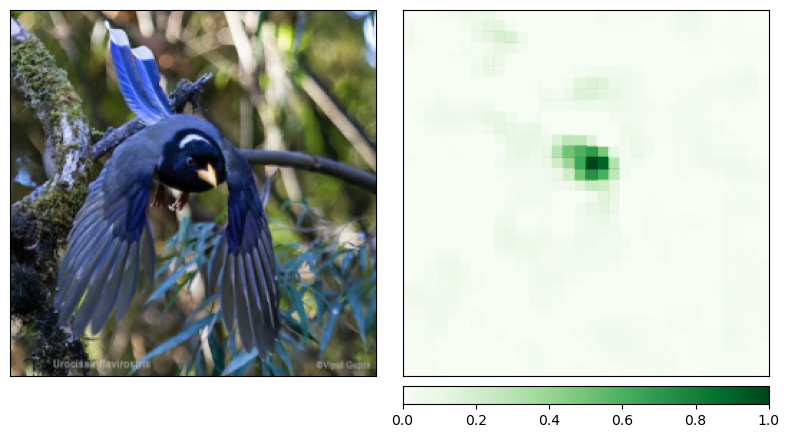

In [41]:
model.to(device)
model = model.eval()
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(transformed_img.to(device),
                                       strides = (3, 8, 8),
                                       target=pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(img),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

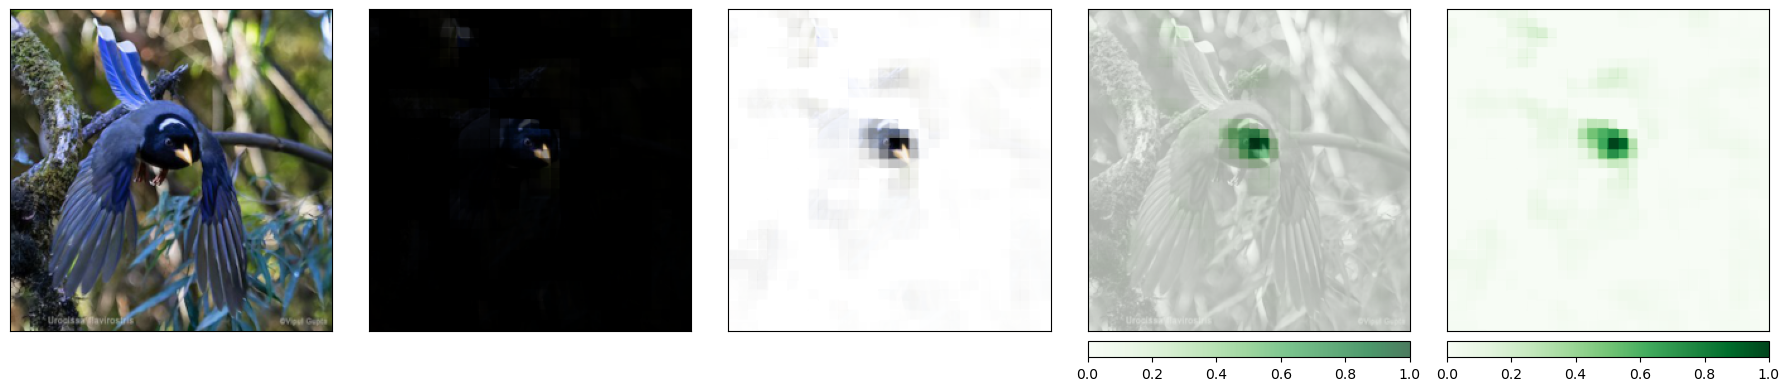

In [42]:
model.to(device)
model = model.eval()
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(transformed_img.to(device),
                                       strides = (3, 8, 8),
                                       target=pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(img.resize((256, 256))),
                                      ["original_image", "masked_image", "alpha_scaling", "blended_heat_map", "heat_map"],
                                      ["all", "positive", "positive", "positive", "positive"],
                                      fig_size=(18, 18),
                                      alpha_overlay=0.7,
                                      show_colorbar=True,
                                      outlier_perc=2)